In [1]:
import math
import os
import json
import random

import torch
import torch.nn as nn
import numpy as np

from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms

from BearRobot.utils import ddp
from torch.utils.data import DistributedSampler
from data.libero.data_process import demo2frames
from data.libero.data_process import get_libero_frame
from mmengine import fileio
import io
import DecisionNCE,torch

import matplotlib
import matplotlib.pyplot as plt
from data.libero.data_process import demo2frames
from collections import OrderedDict
 
frame_length_dict = demo2frames.frame_counts_dict()
base_dir = "/home/dodo/ljx/BearRobot/data/libero/dataset/libero/data_jpg/"
transform = transforms.ToTensor()

/home/dodo/miniconda3/envs/bear_clone/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


===========Currently, DecisionNCE only supports the RN50-CLIP model.    You are welcome to expand DecisionNCE to more and larger models.==============
========= Load Successfully ========


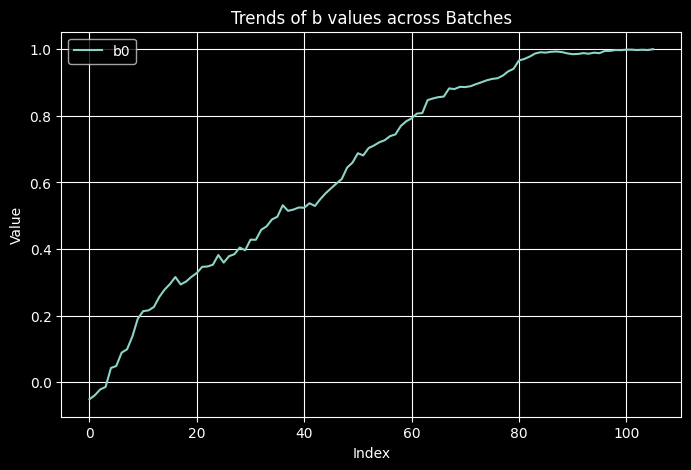

In [2]:
def b_visual(b_list, lang):
              b_list = np.array(b_list)

              plt.figure(figsize=(8, 5))

              for num in range(len(b_list[0])):
                     result = b_list[:, num]
                     
                     plt.plot(result, label=f'b{num}')
                            
              plt.title('Trends of b values across Batches')
              plt.xlabel('Index')
              plt.ylabel('Value')

              plt.legend()
              plt.grid(True)

              # plt.savefig(f'b_trends/{lang}.png')
              plt.show()
              # plt.close()
              
def np_image_to_tensor(image: np.array, normalize_img: bool):
              B, H, W, C = image.shape
              print(B,H,W,C)
              image = image / 255. if image.max() > 10 else image
              image = torch.from_numpy(image).permute(0, 3, 1, 2).to(torch.float32)  # B, C, H, W
              
              if normalize_img:
                     norm_mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1).repeat(B, 1, 1, 1)  # B, C, 1, 1
                     norm_std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1).repeat(B, 1, 1, 1)
                     
                     image = (image - norm_mean) / norm_std
              return image
       
cosine_similarity = torch.nn.functional.cosine_similarity
encoder = DecisionNCE.load("DecisionNCE-P_libero_450ep")
encoder.eval()
lang = "put the wine bottle on top of the cabinet"
lang_embedding = encoder.encode_text(lang)

# ckpt_path = "/home/dodo/wgm/CL/BearRobot/BearRobot/Agent/deployment/experiments/libero/libero_goal/trial_err_ResNet34_one_hot_lang_t_01/latest.pth"
# ckpt_v = fileio.get(ckpt_path)
# with io.BytesIO(ckpt_v) as f:
#        ckpt_v = torch.load(f, map_location='cuda')
# new_ckpt = OrderedDict()
# for key in ckpt_v['v_model'].keys():
#        new_key = key.replace(".module", '')
#        new_ckpt[new_key] = ckpt_v['v_model'][key]
# ckpt_v['v_model'] = new_ckpt
# encoder = V_model(state_dim=9).load_state_dict(ckpt_v['v_model'])
b_list = []

def openimage(path):
       value  = fileio.get(path)
       img_bytes = np.frombuffer(value, np.uint8)
       buff = io.BytesIO(img_bytes)
       img = Image.open(buff).convert('RGB')
       return img

instruction = lang.replace(" ","_")+ "_demo"
demo_paths = demo2frames.get_demos_for_task(instruction, frame_length_dict)
demo_path = random.choice(demo_paths)

T = frame_length_dict[demo_path] - 1
begin_agent_path = os.path.join(base_dir,demo_path,"image0/0.jpg")
end_agent_path = os.path.join(base_dir,demo_path,f"image0/{T}.jpg")

begin_agent_view = transform(np.array(openimage(begin_agent_path))/255).unsqueeze(1).permute(1,0,2,3)
end_agent_view = transform(np.array(openimage(end_agent_path))/255).unsqueeze(1).permute(1,0,2,3)
expert_emb = encoder.encode_image(end_agent_view)

for i in range(T):
       agent_path = os.path.join(base_dir,demo_path,f"image0/{i}.jpg")
       wrist_path = os.path.join(base_dir,demo_path,f"image0/{i}.jpg")
       
       agent_view = transform(np.array(openimage(agent_path))/255).unsqueeze(1).permute(1,0,2,3)
       begin_agent_view = transform(np.array(openimage(agent_path))/255).unsqueeze(1).permute(1,0,2,3)
       
       if i % 10 != 0:
              eval_emb = encoder.encode_image(agent_view)
       else:
              eval_emb = encoder.encode_image(begin_agent_view)
              
       b = cosine_similarity(expert_emb, eval_emb, dim=-1)
       b_list.append(b.cpu().detach().numpy())

b_visual(b_list,lang)

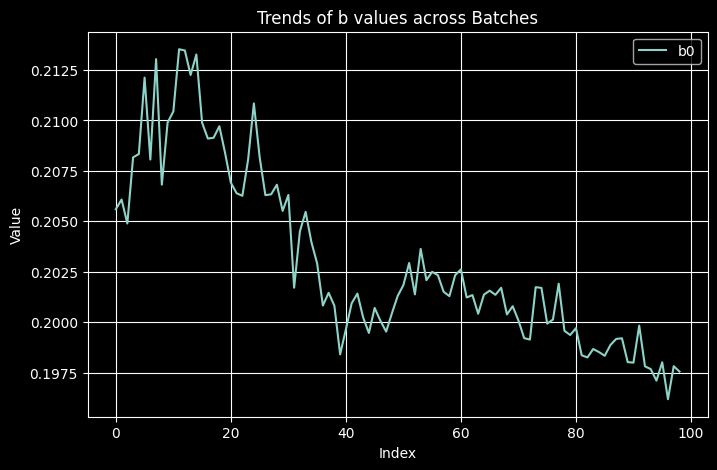

In [4]:
b_list = []
lang = "put the wine bottle on top of the cabinet"
lang_embedding = encoder.encode_text(lang)

for i in range(1,100):
       agent_path = os.path.join("/home/dodo/wgm/CL/BearRobot/BearRobot/Agent/deployment/Err_libero_goal_datasets/put the wine bottle on top of the cabinet/demo4",f"image0/{i}.jpg")
       
       agent_view = transform(np.array(openimage(agent_path))/255).unsqueeze(1).permute(1,0,2,3)
            
       image_embedding = encoder.encode_image(agent_view)
       b = cosine_similarity(lang_embedding, image_embedding, dim=-1)
       b_list.append(b.cpu().detach().numpy())

b_visual(b_list,lang)

In [5]:
import math
import os
import json
import random

import torch
import torch.nn as nn
import numpy as np

from PIL import Image
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms

from BearRobot.utils import ddp
from torch.utils.data import DistributedSampler
from data.libero.data_process import demo2frames
from data.libero.data_process import get_libero_frame
from mmengine import fileio
import io

EPS = 1e-5

frame_length_dic = demo2frames.frame_counts_dict()

def openimage(path):
       value  = fileio.get(path)
       img_bytes = np.frombuffer(value, np.uint8)
       buff = io.BytesIO(img_bytes)
       img = Image.open(buff).convert('RGB')
       return img


def openjson(path):
       value  = fileio.get_text(path)
       dict = json.loads(value)
       return dict
   

class AIRKitchenDataset_err():
       def __init__(
              self,
              base_dir='',
              datalist=['/home/dodo/ljx/BearRobot/data/airkitchen/AIR-toykitchen-ac.json'],
              img_size: int=128,
              frames: int=3,
              view_list: list=['D435_image', 'wrist_image'],
              norm: str=None,
              discretize_actions: bool=False,
              ac_num: int=4,
              statistics: dict=None,
              mask_aug: bool=False,  # True for IVM training, False for normal training
              transform_list: list=None,  # e.g. [transforms.RandomResizedCrop(224, scale=(0.75, 1), interpolation=Image.BICUBIC)], you can feed your own transform
              img_goal: bool=False,
       ):
              self.base_dir = base_dir
              self.img_size = img_size
              self.frames = frames
              self.view_list = view_list
              self.discretize_actions = discretize_actions
              self.norm = norm
              self.ac_num = ac_num
              self.mask_aug = mask_aug
              self.img_goal = img_goal
              
              err_datalist = ["/home/dodo/wgm/CL/BearRobot/BearRobot/Agent/deployment/err_libero_goal-ac.json"]
              self.datalist = []
              self.err_datalist = []
              self.transform_list  = [
                            transforms.ColorJitter(0.2, [0.8, 1.2], [0.8, 1.2], 0.1),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                     ] 
              
              for one_list in datalist:
                     datalist = openjson(one_list)
                     self.datalist += datalist
                     
              for one_list in err_datalist:
                     err_datalist = openjson(one_list)
                     self.err_datalist += err_datalist
                     
              self._statistics(statistics)
              
              if transform_list == None:
                     transform_list  = [
                            transforms.ColorJitter(0.2, [0.8, 1.2], [0.8, 1.2], 0.1),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                     ]  
                     if self.img_size != 0:
                            transform_list.insert(0, transforms.RandomResizedCrop(self.img_size, scale=(0.75, 1), interpolation=Image.BICUBIC))     
              else:
                     transform_list = transform_list  
              self.transform = transforms.Compose(self.transform_list)

       def _statistics(self, statistics=None):
              if statistics is None:
                     all_action = [torch.tensor(data['action'][0]).view(1, -1) for data in self.datalist]
                     actions = torch.cat(all_action)
                     
                     self.a_max = actions.max(0)[0]
                     self.a_min = actions.min(0)[0]
                     self.a_mean = actions.mean(0)
                     self.a_std = actions.std(0)

                     all_state = [torch.tensor(data['state']).view(1, -1) for data in self.datalist]
                     states = torch.cat(all_state)
                     self.s_max = states.max(0)[0]
                     self.s_min = states.min(0)[0]
                     self.s_mean = states.mean(0)
                     self.s_std = states.std(0)                     
              else:
                     self.a_max = torch.tensor(statistics['a_max'])
                     self.a_min = torch.tensor(statistics['a_min'])
                     self.a_mean = torch.tensor(statistics['a_mean'])
                     self.a_std = torch.tensor(statistics['a_std'])

                     self.s_max = torch.tensor(statistics['s_max'])
                     self.s_min = torch.tensor(statistics['s_min'])
                     self.s_mean = torch.tensor(statistics['s_mean'])
                     self.s_std = torch.tensor(statistics['s_std'])                     
              
       
       def discretize(self, tensor, num_bins, min_val, max_val):
              """
              discretize the continuous actions from [min_val, max_val] to num_bins bins
              """
              normalized_tensor = (tensor - min_val) / (max_val - min_val)
              discretized_tensor = torch.floor(normalized_tensor * num_bins).clamp(0, num_bins - 1)
              discretized_tensor = discretized_tensor
              return discretized_tensor

       def aug_mask(self, step, image):
              threshold = np.random.uniform(0.4, 0.9)
              dilate_kernel_size = np.random.randint(3, 20) * 2 + 1

              mask_path = step['mask']
              mask = np.load(mask_path, allow_pickle=True)['arr_0']
              mask_output = np.where(mask > threshold, 1, 0).astype(np.uint8)
              kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(dilate_kernel_size,dilate_kernel_size)) # ksize=7x7,
              mask_output = cv2.dilate(mask_output,kernel,iterations=1).astype(np.float32)
              mask_output = cv2.GaussianBlur(mask_output, (dilate_kernel_size, dilate_kernel_size), 0)[:,:,np.newaxis]
              
              fill_color=(255, 255, 255)
              fill_tensor = torch.tensor(fill_color, dtype=torch.uint8).repeat(mask.shape[0], mask.shape[1], 1)
              masked_image = np.asarray(image).astype(np.float32) * mask  + fill_tensor.numpy() * (1 - mask)
              masked_image = Image.fromarray(masked_image.astype(np.uint8))  # highlight image with mask
              return masked_image
                      
       def __len__(self):
              return len(self.datalist)

       def __getitem__(self, idx):
              err_getitem = False
              # err_getitem = random.choice([True, False])
              if not err_getitem:
                     step = self.datalist[idx]
                     imgs_path = [os.path.join(self.base_dir, step[f'{view}']) for view in self.view_list]
                     end_index = frame_length_dic["/".join(imgs_path[0].split("/")[-5:-2])] - 1
                     if idx == end_index:
                            idx = idx - 1
                            
                     step = self.datalist[idx]
                     imgs_path = [os.path.join(self.base_dir, step[f'{view}']) for view in self.view_list]
                     # actions = step['action'][:self.ac_num]
                     state = step['state']
                     lang = step['instruction']
                     
                     # # action
                     # processed_action = []
                     # for action in actions:
                     #        # discretize the action
                     #        action = torch.tensor(action)
                     #        if self.discretize_actions:
                     #               action[:6] = self.discretize(action[:6], 256, -1., 1.)
                     #               action[-1] = torch.tensor(255) if action[-1] == 1. else torch.tensor(0)
                     #        else:
                     #               if self.norm == 'mean':
                     #                      action = (action - self.a_mean) / self.a_std
                     #               elif self.norm == 'minmax':
                     #                      action = (action - self.a_min) / (self.a_max - self.a_min) * 2 - 1
                     #        processed_action.append(action)
                     # action = torch.cat(processed_action, dim=-1)
                     
                     # state
                     state = torch.tensor(state)
                     state = (state - self.s_mean) / self.s_std
                                   
                     # images
                     images = [openimage(img_path) for img_path in imgs_path]
                     if self.mask_aug:
                            images[0] = self.aug_mask(step, images[0])           
                     images = torch.cat([self.transform(image).unsqueeze(0).unsqueeze(0) for image in images], dim=1)
                     
                     # index
                     current_idx = int(imgs_path[0].split('/')[-1].split('.')[0])

                     #reward
                     if end_index - current_idx <= 5:
                            reward = 0
                     else:
                            reward = -1
                     ### get next state 
                     step_next = self.datalist[idx+1]
                     imgs_path = [os.path.join(self.base_dir, step_next[f'{view}']) for view in self.view_list]
                     # actions = step_next['action'][:self.ac_num]
                     state = step_next['state']
                     lang = step_next['instruction']
                     
                     # action
                     # processed_action = []
                     # for action in actions:
                     #        # discretize the action
                     #        action = torch.tensor(action)
                     #        if self.discretize_actions:
                     #               action[:6] = self.discretize(action[:6], 256, -1., 1.)
                     #               action[-1] = torch.tensor(255) if action[-1] == 1. else torch.tensor(0)
                     #        else:
                     #               if self.norm == 'mean':
                     #                      action = (action - self.a_mean) / self.a_std
                     #               elif self.norm == 'minmax':
                     #                      action = (action - self.a_min) / (self.a_max - self.a_min) * 2 - 1
                     #        processed_action.append(action)
                     # action = torch.cat(processed_action, dim=-1)
                     
                     # state
                     state = torch.tensor(state)
                     state_next = (state - self.s_mean) / self.s_std
                                   
                     # images
                     images = [openimage(img_path) for img_path in imgs_path]
                     if self.mask_aug:
                            images[0] = self.aug_mask(step, images[0])           
                     images_next = torch.cat([self.transform(image).unsqueeze(0).unsqueeze(0) for image in images], dim=1)
                     
                     
                     return_dict = {"imgs": images,
                                   "lang": lang,
                                   "proprio": state,
                                   "t": int(current_idx),
                                   "T": int(end_index),
                                   "imgs_next": images_next,
                                   "proprio_next": state_next,
                                   "reward":reward}
                     
              else:
                     err_length = len(self.err_datalist) - 1
                     idx = random.randint(0,err_length-1)   
                     step = self.err_datalist[idx]
                     imgs_path = [os.path.join(self.base_dir, step[f'{view}']) for view in self.view_list]
                     
                     end_index = frame_length_dic["libero_goal/{}_demo/{}".format(*imgs_path[0].replace(" ", "_").split("/")[-4:-2])] - 1 
                            
                     step = self.err_datalist[idx]
                     state = step['state']
                     lang = step['instruction']
                     reward = step["reward"]
                     
                     # state
                     state = torch.tensor(state)
                     state = (state - self.s_mean) / self.s_std
                                   
                     # images
                     images = [openimage(img_path) for img_path in imgs_path]
                     if self.mask_aug:
                            images[0] = self.aug_mask(step, images[0])           
                     images = torch.cat([self.transform(image).unsqueeze(0).unsqueeze(0) for image in images], dim=1)
                     
                     # index
                     current_idx = imgs_path[0].split('/')[-1].split('.')[0] #TODO 改一下

                     ### get next state 
                     step_next = self.err_datalist[idx+1]
                     imgs_path = [os.path.join(self.base_dir, step_next[f'{view}']) for view in self.view_list]
                     state = step_next['state']
                     lang = step_next['instruction']
                     
                     # state
                     state = torch.tensor(state)
                     state_next = (state - self.s_mean) / self.s_std
                                   
                     # images
                     images = [openimage(img_path) for img_path in imgs_path]
                     if self.mask_aug:
                            images[0] = self.aug_mask(step, images[0])           
                     images_next = torch.cat([self.transform(image).unsqueeze(0).unsqueeze(0) for image in images], dim=1)
                     
                     
                     return_dict = {"imgs": images,
                                   "lang": lang,
                                   "proprio": state,
                                   "t": int(current_idx),
                                   "T": int(end_index),
                                   "imgs_next": images_next,
                                   "proprio_next": state_next,
                                   "reward":reward}
                     
              # return image goal or not
              if self.img_goal:
                     img_begin_path, img_end_path = get_libero_frame.get_demofixed_idx_begin_frame(step,self.base_dir,frame_length_dic)
                     transform = transforms.ToTensor()
                     img_begin = transform(openimage(img_begin_path))
                     img_end = transform(openimage(img_end_path))
                     return_dict.update({"img_begin": img_begin, "img_end": img_end})
                           
              return return_dict
          
          
   
   
def AIRKitchenDataLoader_err(
       base_dir: str='',
       datalist: list=['/home/dodo/ljx/BearRobot/data/bridge/AIR-toykitchen.json'],
       img_size: int=128,
       frames: int=1,
       view_list: list=['D435_image', 'wrist_image'],
       norm: str="minmax",
       discretize_actions: bool=False,
       batch_size: int=64,
       num_workers: int=8,
       pin_mem: bool=True,
       ac_num: int=4,
       transform_list: list=None,
       img_goal: bool=False,
       **kwargs,
):
       dataset = AIRKitchenDataset_err(base_dir=base_dir,
                                   datalist=datalist,
                                   frames=frames, 
                                   img_size=img_size, 
                                   view_list=view_list, 
                                   discretize_actions=discretize_actions, 
                                   norm=norm,
                                   ac_num=ac_num,
                                   transform_list=transform_list,
                                   img_goal=img_goal)
       
       num_tasks = ddp.get_world_size()
       global_rank = ddp.get_rank()
       sampler = DistributedSampler(
            dataset, num_replicas=num_tasks, rank=global_rank, shuffle=True
       )
       
       dataloader = DataLoader(
              dataset, 
              sampler=sampler,
              batch_size=batch_size // num_tasks, 
              num_workers=num_workers,
              pin_memory=pin_mem,
              drop_last=True
       )
       
       statistics = {"a_min": dataset.a_min.cpu().numpy().tolist(),
                     "a_max": dataset.a_max.cpu().numpy().tolist(),
                     "a_mean": dataset.a_mean.cpu().numpy().tolist(),
                     "a_std": dataset.a_std.cpu().numpy().tolist(),
                     "s_min": dataset.s_min.cpu().numpy().tolist(),
                     "s_max": dataset.s_max.cpu().numpy().tolist(),
                     "s_mean": dataset.s_mean.cpu().numpy().tolist(),
                     "s_std": dataset.s_std.cpu().numpy().tolist(),}
       return dataloader, statistics
  

In [3]:
import numpy as np
import torch

# 读取 npy 文件
file_path = '/home/dodo/ljx/BearRobot/data/libero/dataset/libero/data_jpg/libero_goal/put_the_wine_bottle_on_the_rack_demo/demo_27/state.npy'
state = np.load(file_path)

# 提取第123到133行的数据
state_subset = state[0:4]  # 注意：索引从0开始，因此123-133行对应122-132

# 转换为torch tensor
state_tensor = torch.tensor(state_subset)

# 假设s_mean和s_std已定义
s_mean = torch.tensor(([ 0.0284, -0.0273, -0.0925,  0.0121,  1.0687,  0.9168,  0.1214, -0.1000,
         0.0679]))
s_std = torch.tensor(([0.0149, 0.0149, 0.1145, 0.1156, 0.1046, 0.1508, 0.2695, 0.1359, 0.1274]))

# 归一化处理
state_normalized = (state_tensor - s_mean) / s_std

print(state_normalized)


tensor([[ 0.5246, -0.6001, -0.9081, -0.0585,  1.0077,  0.5490, -0.4183,  0.5522,
         -0.4508],
        [ 0.6064, -0.6822, -0.8826, -0.0588,  0.9972,  0.5480, -0.4179,  0.5221,
         -0.4246],
        [ 0.6522, -0.7281, -0.8550, -0.0564,  0.9856,  0.5465, -0.4170,  0.4849,
         -0.3920],
        [ 0.6777, -0.7539, -0.8238, -0.0500,  0.9726,  0.5441, -0.4126,  0.4398,
         -0.3457]])
